# CLEAN DATA

Remove the galactic dust, the point sources and the galactic dipole from RAW data; this is necessary to make a correct classification of the glitches.

In [1]:
%matplotlib inline

# Reading files
from astropy.io import fits
import h5py

# Scientific computing
import numpy as np
import pandas as pd
from astropy.coordinates import spherical_to_cartesian

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#sns.set_context('paper')

# Other
import os
import time as pytime
import subprocess

## Model constants and parameters
Calibration constants.:

Operating day, detector of interest and file locations:

In [2]:
OPERATING_DAY = '095'
DETECTOR = '143-5'

FILENAME_PTG = 'D:/Tesi/data/HFI-143/HFI_TOI_143-PTG_R2.01_OD0' + OPERATING_DAY + '.fits'
FILENAME_RAW = 'D:/Tesi/data/HFI-143/HFI_TOI_143-RAW_R2.00_OD0' + OPERATING_DAY + '.fits'
FILENAME_SCI = 'D:/Tesi/data/HFI-143/HFI_TOI_143-SCI_R2.00_OD0' + OPERATING_DAY + '.fits'
DIR = 'ris/ipynb_test-clean_data-moving_average'

Constants:

In [3]:
# Constants and conversion constants
with fits.open(FILENAME_SCI) as f:
    T_CMB = f[DETECTOR].header['T_CMB']
    SOLSYSDIR_ECL_COLAT_RAD = f[DETECTOR].header['ECL_THE']
    SOLSYSDIR_ECL_LONG_RAD = f[DETECTOR].header['ECL_PHI']
    SOLSYSSPEED_M_S = f[DETECTOR].header['SOLSPEED']
    MAIN_LENGTH = len(f[DETECTOR].data.field('SIGNAL'))
    CALIBRATION_CONSTANT = f[DETECTOR].header['CALIB']
    ZERO_POINT = f[DETECTOR].header['ZERO-PT']

# Number of elements of the average
MA_LENGTH = 649346
# New length
NEW_LENGTH = MAIN_LENGTH - MA_LENGTH + 1

SPEED_OF_LIGHT_M_S = 2.99792458e8
PLANCK_H_MKS = 6.62606896e-34
BOLTZMANN_K_MKS = 1.3806504e-23

SOLSYS_SPEED_VEC_M_S = SOLSYSSPEED_M_S * np.array(
                                                  [
                                                   np.sin(SOLSYSDIR_ECL_COLAT_RAD) * np.cos(SOLSYSDIR_ECL_LONG_RAD),
                                                   np.sin(SOLSYSDIR_ECL_COLAT_RAD) * np.sin(SOLSYSDIR_ECL_LONG_RAD),
                                                   np.cos(SOLSYSDIR_ECL_COLAT_RAD),
                                                  ]
                                                 )

## Cleaning model

Since the purpose of this thesis is to detect glitches and not to clean up the RAW signal from the galactic signal and other signals, all points that are on the galactic plane or coincide with a point source can be ignored without any consequences.

### Mask

Load galactic dust and point sources flags from the SCI data. SCI data, taken as PTG and RAW data from the Planck Legacy Archive (PLA), are the so-called _scientific data_ (already cleaned of various effects and glitches) and each data has a flag that indicates a peculiarity, i.e. point object, planet, galaxy plane and others. In particular, the flags of interest are those concerning the _galactic plane_ and the _point source_:
```
bit 4: StrongSignal; 1 = In Galactic plane
bit 5: StrongSource; 1 = On point source
```
Data with those flags must be discarded.

In [4]:
# Open SCI data and load the 'FLAG' field
with fits.open(FILENAME_SCI) as f:
    SCI_FLAG_bits = f[DETECTOR].data.field('FLAG')
    
# Unpacks bits
SCI_FLAG_bits = np.unpackbits(SCI_FLAG_bits[:, np.newaxis], axis=1)

# Read the 4th and 5th bits
SCI_FLAG_GD = SCI_FLAG_bits[:,3]
SCI_FLAG_PS = SCI_FLAG_bits[:,4]

In [5]:
# Sum the two masks
MASK = SCI_FLAG_GD + SCI_FLAG_PS
# Make 'average'
MASK = MASK[:NEW_LENGTH]

# Every value above 0 means an unacceptable value
MASK[MASK != 0] = 1

### RAW data preparation

In [6]:
# Open the voltages
with fits.open(FILENAME_RAW) as f:
    obt = f['OBT'].data.field('OBT')
    data_raw = f[DETECTOR].data.field('RAW')

#### DATA

Data calibration allows us to compare data from different detectors: to do this, we use calibration constants extracted from SCI data. The complete equation is:

$$
S_{\text{calibrated}} = \frac{ (S - C_{\text{zero-point}}) \cdot C_{\text{V-to-W}} }{ C_{\text{calibration}} }  \qquad \text{with} \qquad S = \frac{ S_{\text{corrected}} - \text{movingAverage}(S_{\text{corrected}}, N_{\text{one-hour-data}}) }{ N_{\text{one-hour-data}} }
$$

where $S_{\text{corrected}}$ is $S_{\text{raw}}$, but with the odd components (we start from zero) of the array with a changed sign.

We **miss** the $C_{\text{V-to-W}}$ constant, so we use $C_{\text{V-to-W}} = 1$.

In [7]:
data_raw_corrected = np.array(data_raw)
data_raw_corrected[1::2] = - data_raw_corrected[1::2]

To make the moving average, we use `pandas.Series(x).rolling(window=N).mean()` instead of a numpy method such as `np.convolve(x, np.ones((N,))/N, mode='valid')` because the speed per loop is much greater:
```python
In [1]: import numpy as np

In [2]: import pandas as pd

In [3]: x = np.random.random(100000)

In [4]: N = 10000

In [5]: %timeit np.convolve(x, np.ones((N,))/N, mode='valid')
158 ms ± 7.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

In [6]: %timeit pd.Series(x).rolling(window=N).mean().iloc[N-1:].values
3.13 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
```
To get a numpy array from the pandas dataframe we use `.iloc[N-1:].values` ; the new number of elements of the array is:
```python
NEW_LENGTH = len(x) - N + 1
```


In [8]:
# Moving average
data_ma = pd.Series(data_raw_corrected).rolling(window=MA_LENGTH).mean().iloc[MA_LENGTH-1:].values
data = (data_raw_corrected[:NEW_LENGTH] - data_ma) / MA_LENGTH
# Calibrate values
data = (data - ZERO_POINT) / CALIBRATION_CONSTANT

Now data are in $\text{T}_{\text{cmb}} \text{V} \text{W}^{-1}$ because we miss $C_{\text{V-to-W}}$.

#### TIME

First the OBT (_on board time_) must be converted to seconds using a conversion constant $C_{\text{time}}$ and removing the offset:

$$
\text{time} = \frac{\text{OBT} - \text{OBT}_0}{C_{\text{time}}} \qquad \text{with} \qquad C_{\text{time}} = 65536
$$

Then we take the first `NEW_LENGTH` elements.

In [9]:
# Convert the time from OBT clock to seconds and remove the offset
time = (obt - obt[0]) / 65536
# Take the correct number of elements
time = time[:NEW_LENGTH]

#### GALACTIC DIPOLE

The galactic dipole is caused by the motion of the solar system around the galactic center; the equation is:

$$
D(x,t) = T_{\text{cmb}} \left( \frac{1}{\gamma(t) \left( 1 - \vec{\beta}(t) \cdot \vec{x} \right)} - 1 \right)
$$

`get_dipole_temperature(directions)` : given one or more one-length versors, return the intensity of the CMB dipole; vectors must be expressed in the ecliptic coordinate system.

In [10]:
def get_dipole_temperature(directions):
    
    beta = SOLSYS_SPEED_VEC_M_S / SPEED_OF_LIGHT_M_S
    gamma = (1 - np.dot(beta, beta)) ** (-0.5)
    
    return T_CMB * (1.0 / (gamma * (1 - np.dot(directions, beta))) - 1.0)

Compute the galactic dipole.

In [11]:
# Open PTG data and load the 'THETA' and 'PHI' fields
with fits.open(FILENAME_PTG) as inpf:
    theta, phi = [inpf[DETECTOR].data.field(x) for x in ('THETA', 'PHI')]
    
# Get the directions (vectors) directly from the angular coordinates
dir_x, dir_y, dir_z = np.array(spherical_to_cartesian(np.ones(MAIN_LENGTH),(np.pi/2-theta),(phi)))
# Compute dipole temperature
dipole = get_dipole_temperature(np.concatenate((dir_x[:, np.newaxis], dir_y[:, np.newaxis], dir_z[:, np.newaxis]), axis=1)[:NEW_LENGTH])

Here an example of the galactic dipole.

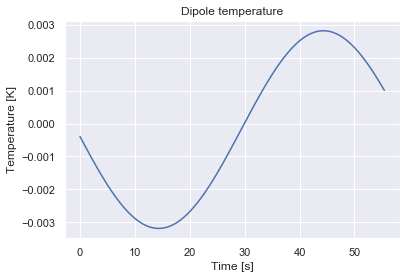

In [12]:
plt.plot(time[:10000], dipole[:10000])
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')
plt.title('Dipole temperature')
plt.show()

### Remove galactic dipole signal

##### **WARNING**: USING SCI DATA, WE HAVE CONVERTED RAW DATA FROM VOLTAGES TO TEMPERATURES, SO _MAYBE_ WE CAN SIMPY SUBTRACT THE GALACTIC DIPOLE FROM THE DATA. IT DEPENDS ON THE CONVERSION CONSTANT WE MISS.

Apply a least squares method to remove the galactic dipole. We must use this method because `data` and `dipole` do not have the same units of measurement. Since the RAW data are modulated by the dipole, it's possible to find a correlation of the type $y = m x + q$:

$$
S_{\text{calibrated}} = m \cdot D + q
$$

where $S_{\text{calibrated}}$ is the signal after the calibration process (in $\text{T}_{\text{cmb}} \text{V} \text{W}^{-1}$) and $D$ is the galactic dipole (in $\text{T}_{\text{cmb}}$).

In [13]:
# Make the regression
sol_m, sol_q = np.linalg.lstsq(dipole[:, np.newaxis] * [1, 0] + [0, 1], data, rcond=None)[0]
# Print solutions
print('m:', sol_m)
print('q:', sol_q)

m: -959.1053094646409
q: -0.18629657118727078


Here we can see the correlation we have found.

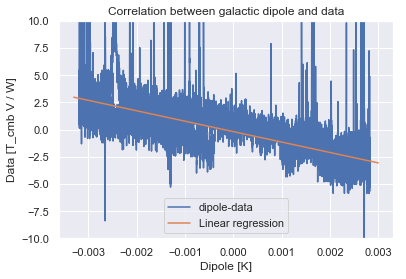

In [14]:
plt.plot(dipole[:10000], data[:10000])
x_linreg = np.linspace(-0.0033, 0.003, 10)
plt.plot(x_linreg, x_linreg * sol_m + sol_q)
plt.ylim(-10, 10)
plt.title('Correlation between galactic dipole and data')
plt.xlabel('Dipole [K]')
plt.ylabel('Data [T_cmb V / W]')
plt.legend(['dipole-data', 'Linear regression'])
plt.show()

At this point, the final voltage will be:

$$
S_{\text{final}} = S_{\text{calibrated}} - (m \cdot D + q)
$$

In [15]:
# Take the dipole out of the data
data_final = data - (dipole * sol_m + sol_q)

Plot data before and after the dipole correction.

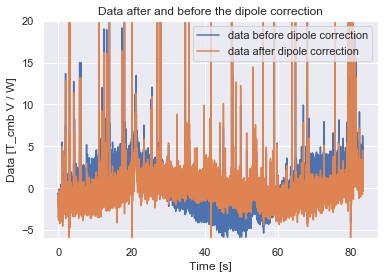

In [16]:
plt.plot(time[:15000], data[:15000])
plt.plot(time[:15000], data_final[:15000])
plt.title('Data after and before the dipole correction')
plt.xlabel('Time [s]')
plt.ylabel('Data [T_cmb V / W]')
plt.legend(['data before dipole correction', 'data after dipole correction'])
plt.ylim(-6, 20)
plt.show()

### Apply mask

In [17]:
# Take out from the data the directions corresponding to the galactic dust mask
data_cleaned = data_final[MASK == 0]
holed_raw = data[MASK == 0]
# Take out also on the time - this way I can have 'holes' in the graph
time_cleaned = time[MASK == 0]

### Save data

We use the Pandas interface to PyTables / HDF5 (speed and compression).

In [18]:
if not os.path.exists(DIR):
    print('Creating "' + DIR + '" directory')
    os.makedirs(DIR)

# Save time_cleaned and data_cleaned as Pandas DataFrame
with pd.HDFStore(DIR + '/OUT-cleaned.h5') as out_file:
    out_file.put(OPERATING_DAY + '/' + DETECTOR, pd.DataFrame({'time_cleaned': time_cleaned, 'data_cleaned': data_cleaned}, columns=['time_cleaned', 'data_cleaned']))

Creating 'ris/ipynb_test-clean_data-moving_average' directory


C:\Users\paolo\Miniconda3\envs\idp\lib\site-packages\tables\path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '095'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
C:\Users\paolo\Miniconda3\envs\idp\lib\site-packages\tables\path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '143-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


In [19]:
# Write attributes
with h5py.File(DIR + '/OUT-cleaned.h5') as f:
    f.attrs['TITLE'] = np.string_('ipynb_test - Data cleaning output file')
    f.attrs['VERSION'] = np.string_('Date: ' + pytime.asctime() + ' | Script name: clean_data-moving_average.ipynb | Script commit ID: ' + subprocess.run(['git', 'log', '-1', '--format=%H', 'clean_data-moving_average.ipynb'], stdout=subprocess.PIPE).stdout.decode('ASCII').rstrip())

In [20]:
# Print a summary
with pd.HDFStore(DIR + '/OUT-cleaned.h5', 'r') as out_file:
    print(out_file.info())
# Read attributes to verify
print('\nAttributes:')
with h5py.File(DIR + '/OUT-cleaned.h5', 'r') as f:
    print(f.attrs['TITLE'])
    print(f.attrs['VERSION'])

<class 'pandas.io.pytables.HDFStore'>
File path: ris/ipynb_test-clean_data-moving_average/OUT-cleaned.h5
/095/143-5            frame        (shape->[13037553,2])

Attributes:
b'ipynb_test - Data cleaning output file'
b'Date: Sat Sep  7 00:15:05 2019 | Script: clean_data-moving_average.ipynb | GitHub commit ID: 6878c51e60b8c8c4b06b94e803db61b40e808965'


## Plot data

In [21]:
if not os.path.exists(DIR + '/plots'):
    print('Creating "' + DIR + '/plots" directory')
    os.makedirs(DIR + '/plots')

Creating 'ris/ipynb_test-clean_data-moving_average/plots' directory


### Galactic dipole - first $120\text{s}$

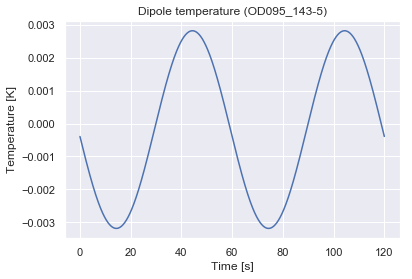

In [22]:
index = time < 120.
plt.plot(time[index], dipole[index])
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')
plt.title('Dipole temperature (OD' + OPERATING_DAY + '_' + DETECTOR  + ')')
plt.savefig(DIR + '/plots/OD' + OPERATING_DAY + '_' + DETECTOR + '-dipole_example.png', dpi=600)
plt.show()
plt.close()

### Linear regression - first $120\text{s}$

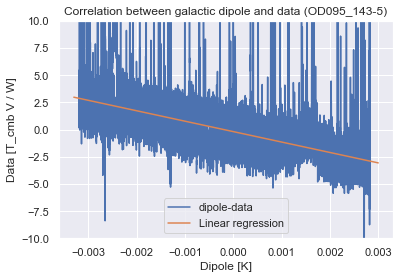

In [23]:
index = time < 120.
plt.plot(dipole[index], data[index])
x_linreg = np.linspace(-0.0033, 0.003, 10)
plt.plot(x_linreg, x_linreg * sol_m + sol_q)
plt.ylim(-10, 10)
plt.title('Correlation between galactic dipole and data (OD' + OPERATING_DAY + '_' + DETECTOR  + ')')
plt.xlabel('Dipole [K]')
plt.ylabel('Data [T_cmb V / W]')
plt.legend(['dipole-data', 'Linear regression'])
plt.savefig(DIR + '/plots/OD' + OPERATING_DAY + '_' + DETECTOR + '-dipole_data_correlation.png', dpi=600)
plt.show()
plt.close()

### Comparison between RAW data and cleaned data - $30\text{s}$

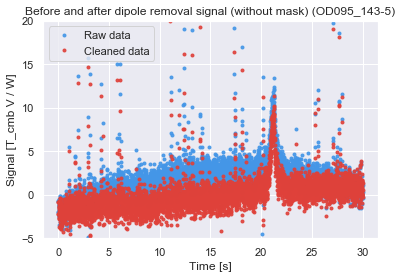

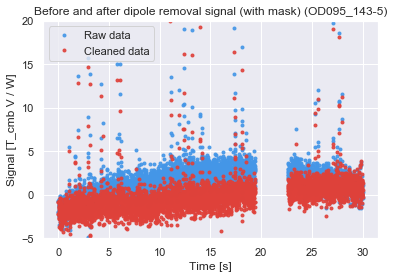

In [24]:
index = time < 30.
plt.plot(time[index], data[index], marker='.', linestyle='none', color='#4496e7', alpha=0.9, label='with dipole')
plt.plot(time[index], data_final[index], marker='.', linestyle='none', color='#df413a', alpha=0.9, label='without dipole')
plt.ylim(-5,20)
plt.title('Before and after dipole removal signal (without mask) (OD' + OPERATING_DAY + '_' + DETECTOR  + ')')
plt.xlabel('Time [s]')
plt.ylabel('Signal [T_cmb V / W]')
plt.legend(['Raw data', 'Cleaned data'])
plt.savefig(DIR + '/plots/OD' + OPERATING_DAY + '_' + DETECTOR + '-first30s-data_raw_signal.png', dpi=600)
plt.show()
plt.close()

index = time_cleaned < 30.
plt.plot(time_cleaned[index], holed_raw[index], marker='.', linestyle='none', color='#4496e7',  alpha=0.9, label='with dipole')
plt.plot(time_cleaned[index], data_cleaned[index], marker='.', linestyle='none', color='#df413a', alpha=0.9, label='without dipole')
plt.ylim(-5,20)
plt.title('Before and after dipole removal signal (with mask) (OD' + OPERATING_DAY + '_' + DETECTOR  + ')')
plt.xlabel('Time [s]')
plt.ylabel('Signal [T_cmb V / W]')
plt.legend(['Raw data', 'Cleaned data'])
plt.savefig(DIR + '/plots/OD' + OPERATING_DAY + '_' + DETECTOR + '-first30s-data_cleaned_signal.png', dpi=600)
plt.show()
plt.close()

### Comparison between RAW data and cleaned data - random $30\text{s}$